# Imports

In [1]:
import torch as ch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

import tqdm
from tqdm.contrib.concurrent import thread_map
from functools import partial

import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

from scipy.special import softmax
from scipy.stats import entropy, mode
from scipy.sparse import csr_matrix

import os
from robustness.tools.vis_tools import show_image_row

# Target Computation

In [56]:
class TargetComputer:
    def __init__(self, logits, labels, out_path = None):
        self.logits = logits
        self.labels = labels
        self.out_path = out_path
        self.margins_result = None
        self.std_result = None
        self.ece_result = None
        self.entropy_result = None
        
    def margins(self):
        def compute(idx, logits, labels, result):
            logits_idx = logits[idx].copy() # Copy the logits for the current mask/index
            indices = np.arange(labels.shape[0]) # Create an array of incremental indices for future indexing

            correct = logits_idx[indices, labels] # Set the correct logits of each sample to be the ones indexed by the labels
            logits_idx[indices, labels] = -np.inf # Set the logit corresponding to the correct index to -inf
            top_incorrect = logits_idx.max(axis = -1) # Set the highest incorrect logit to be the max of the logits along the logits axis

            result[idx] = correct - top_incorrect # The margin is difference between the correct and highest incorrect logit
            
            
        result = np.zeros((self.logits.shape[0], self.logits.shape[1]))
        margins_partial = partial(compute,
                                  logits = self.logits,
                                  labels = self.labels,
                                  result = result)
        thread_map(margins_partial, np.arange(self.logits.shape[0]))
        self.margins_result = result
        
        return result
    
    
    #TODO: Add another std implementation that computes std along the samples axis instead of the logits axis
    def std(self):
        def compute(idx, logits, result):
            logits_idx = logits[idx].copy() # Copy the logits for the current mask/index
    
            result[idx] = np.std(logits_idx, axis = -1) # Compute stdev along the logits axis
        
        
        result = np.zeros((self.logits.shape[0], self.logits.shape[1]))
        std_partial = partial(compute,
                              logits = self.logits,
                              result = result)
        thread_map(std_partial, np.arange(self.logits.shape[0]))
        self.std_result = result
        
        return result
    
    
    #ECE = Weighted Average(|Accuracy_m - Confidence_m|) ---- Weighted by the relative proportion of each bin (m is the bin index)
    def ece(self, n_bins = 10):
        def compute(idx, n_bins, logits, labels, result):
            logits_idx = logits[idx].copy() # Copy the logits for the current mask/index
            probs = softmax(logits_idx, axis = 1) # Apply softmax to logits
            
            bin_edges = np.arange(start = 0, stop = 1 + 1/n_bins, step = 1/n_bins) # Set the bin edges 
            bin_lefts = bin_edges[:-1] 
            bin_rights = bin_edges[1:]

            conf = np.max(probs, axis = -1) # Confidences = maximum softmax probabilities
            preds = np.argmax(probs, axis = -1) # Predictions = indices of maximum softmax probabilities
            correct = (preds == labels) # Find correct predictions

            curr_ece = 0

            for bin_left, bin_right in zip(bin_lefts, bin_rights):
                inside = (conf > bin_left) * (conf <= bin_right) # Find confidences that fall inside the current bin
                weight = inside.astype(float).mean() # Weight = proportion of confidences inside the currrent bin
                if weight > 0:
                    acc_bin = correct[inside].astype(float).mean() # Bin Accuracy = mean of 1(y^ = y)
                    conf_bin = conf[inside].astype(float).mean() # Bin Confidence = mean of confidences inside
                    curr_ece += abs(acc_bin - conf_bin) * weight # ECE += |Bin Accuracy - Bin Conf.| * weight
            
            result[idx] = curr_ece
            
            
        result = np.zeros(self.logits.shape[0])
        ece_partial = partial(compute,
                              n_bins = n_bins,
                              logits = self.logits,
                              labels = self.labels,
                              result = result)
        thread_map(ece_partial, np.arange(self.logits.shape[0]))
        self.ece_result = result
        
        return result
    
    
    def entropy(self):
        def compute(idx, logits, result):
            logits_idx = logits[idx].copy() # Copy the logits for the current mask/index
            probs_idx = softmax(logits_idx, axis = 1) # Apply softmax to logits
            
            result[idx] = entropy(probs_idx, axis = 1) # Compute entropy
            
        
        result = np.zeros((self.logits.shape[0], self.logits.shape[1]))
        entropy_partial = partial(compute,
                                  logits = self.logits,
                                  result = result)
        thread_map(entropy_partial, np.arange(self.logits.shape[0]))
        self.entropy_result = result
        
        return result
    
    
    
    def save_result(self, target = 'margins'):
        results = {
            'margins': self.margins_result,
            'std': self.std_result,
            'ece': self.ece_result,
            'entropy': self.entropy_result
        }
        
        result = np.lib.format.open_memmap(os.path.join(self.out_path, target + '.npy'), mode = 'w+', shape = results[target].shape)
        result[:] = results[target][:]
        result.flush()

## Reading Pseudo-labels

In [57]:
pseudo_logits = np.lib.format.open_memmap('/home/gridsan/ahazimeh/src/data-rv/results/result_2/pseudo_logits.npy', mode = 'r')
pseudo_labels = np.argmax(pseudo_logits, axis = -1)

## Computing Datamodel Targets

In [58]:
val_logits = np.lib.format.open_memmap('/home/gridsan/ahazimeh/src/data-rv/results/result_2/val_logits.npy', mode = 'r')
tc = TargetComputer(logits = val_logits,
                    labels = pseudo_labels,
                    out_path = '/home/gridsan/ahazimeh/src/data-rv/results/result_2')

### Margins

In [59]:
margins = tc.margins()

### Entropy

In [60]:
entropy = tc.entropy()

### Saving Targets

In [61]:
tc.save_result(target = 'margins')
tc.save_result(target = 'entropy')

\
\
\
\----------------------------------------------------------------\
**STOP! Compute datamodels before proceeding!**\
\----------------------------------------------------------------\
\
\
\
\


# Autolabelling

In [36]:
class Utils:
    def __init__(self, dm_path, ds_path):
        try:
            self.datamodels = ch.load(dm_path)['weight'].numpy()
        except:
            self.datamodels = ch.load(dm_path, map_location=ch.device('cpu'))['weight'].numpy()
        self.ds_train = CIFAR10(root = ds_path,
                          download = False,
                          train = True,
                          transform = ToTensor())
        self.ds_val = CIFAR10(root = ds_path,
                          download = False,
                          train = False,
                          transform = ToTensor())
        self.classes = {0: 'plane',
                        1: 'car', 
                        2: 'bird', 
                        3: 'cat',
                        4: 'deer', 
                        5: 'dog', 
                        6: 'frog', 
                        7: 'horse', 
                        8: 'ship', 
                        9: 'truck'}
        self.trans_embeds = None
        self.clusters = None
        self.cluster_labels = None
        
    
    def PCA(self, n_components = 100):
        embeds = csr_matrix(self.datamodels)
        svd = TruncatedSVD(n_components = n_components, random_state = 42)
        svd.fit(embeds)
        self.trans_embeds = svd.components_
        
        return self.trans_embeds
    
    
    def compute_clusters(self):
        self.clusters = []
        max_proj_ind = np.argmax(np.abs(self.trans_embeds), axis = 0)
        for ind in range(self.trans_embeds.shape[0]):
            cluster = np.argwhere(max_proj_ind == ind).squeeze()
            if cluster.shape == ():
                cluster = np.expand_dims(cluster, axis = 0)
            if cluster.shape[0] > 0:
                self.clusters.append(cluster)
        
        return self.clusters
    
    
    def compute_clusters_split(self):
        self.clusters = []
        max_proj_ind = np.argmax(np.abs(self.trans_embeds), axis = 0)
        for ind in range(self.trans_embeds.shape[0]):
            cluster = np.argwhere(max_proj_ind == ind).squeeze()
            if cluster.shape == ():
                cluster = np.expand_dims(cluster, axis = 0)
            cluster_pos = cluster[np.argwhere(self.trans_embeds[max_proj_ind[cluster], cluster] > 0)].squeeze()
            cluster_neg = cluster[np.argwhere(self.trans_embeds[max_proj_ind[cluster], cluster] < 0)].squeeze()

            if cluster_pos.shape == ():
                cluster_pos = np.expand_dims(cluster_pos, axis = 0)
            if cluster_neg.shape == ():
                cluster_neg = np.expand_dims(cluster_neg, axis = 0)

            if cluster_pos.shape[0] > 0:
                self.clusters.append(cluster_pos)
            if cluster_neg.shape[0] > 0:
                self.clusters.append(cluster_neg)
                
        return self.clusters
    
    
    def compute_cluster_labels(self, pct):
        self.cluster_labels = []
        for i in range(len(self.clusters)):
            samples = np.random.choice(self.clusters[i], size = int(np.ceil((pct / 100) * self.clusters[i].shape[0])))
            labels = np.array(self.ds_val.targets)[samples]
            self.cluster_labels.append(mode(labels)[0][0])
            
        return self.cluster_labels
    
    
    def cluster_accuracy(self):
        correct = 0
        for i in range(len(self.clusters)):
            correct += (np.array(self.ds_val.targets)[self.clusters[i]] == self.cluster_labels[i]).sum()

        return correct / 100

    
    def vis_PC(self, idx = 0, N = 5, row_label = None):
        assert self.trans_embeds.all() != None, "Principal components not computed. Call PCA.compute() before visualization."
        assert idx >= 0 and idx < self.trans_embeds.shape[0], "PC index out-of-range."
        
        sorted_embed_inds = np.argsort(self.trans_embeds[idx], axis = -1)
        top_N_inds = sorted_embed_inds[-N:][::-1]
        bot_N_inds = sorted_embed_inds[:N][::-1]

        top_N_images, bot_N_images, top_N_labels, bot_N_labels = [], [], [], []
        for i in range(N):
            top_N_images.append(self.ds_val[top_N_inds[i]][0])
            bot_N_images.append(self.ds_val[bot_N_inds[i]][0])
            top_N_labels.append('↑' * (N - i) + '\n' + self.classes[self.ds_val[top_N_inds[i]][1]])
            bot_N_labels.append('↓' * (i + 1) + '\n' + self.classes[self.ds_val[bot_N_inds[i]][1]])

        images = top_N_images + bot_N_images
        labels = top_N_labels + bot_N_labels

        show_image_row([images], ylist = row_label, tlist = [labels])
        
    def vis_top_PCs(self, N = 5, M = 5, row_labels = None):
        for idx in range(M):
            self.vis_PC(idx = idx, N = N, row_label = row_labels[idx] if row_labels else None)
    
    def vis_all_PCs(self, N = 5, row_labels = None):
        for idx in range(self.trans_embeds.shape[0]):
            self.vis_PC(idx = idx, N = N, row_label = row_labels[idx] if row_labels else None)
            
            
    
    def vis_infl(self, idx = 0, N = 5, reverse = False, row_label = None):
        val_image = self.ds_val[idx][0]
        val_label = self.classes[self.ds_val[idx][1]]

        sorted_infls = np.argsort(self.datamodels[:, idx])
        top_N_inds = sorted_infls[-N:][::-1]
        bot_N_inds = sorted_infls[:N][::-1]

        top_N_images = [self.ds_train[top_N_inds[i]][0] for i in range(N)]
        top_N_labels = ['↑' * (N - i) + '\n' + self.classes[self.ds_train[top_N_inds[i]][1]] for i in range(N)]
        bot_N_images = [self.ds_train[bot_N_inds[i]][0] for i in range(N)]
        bot_N_labels = ['↓' * (i + 1) + '\n' + self.classes[self.ds_train[bot_N_inds[i]][1]] for i in range(N)]

        images = [val_image] + top_N_images + bot_N_images if not reverse else [val_image] + bot_N_images[::-1] + top_N_images[::-1]
        labels = [f'[TARGET]\n{val_label}'] + top_N_labels + bot_N_labels if not reverse else [f'[TARGET]\n{val_label}'] + bot_N_labels[::-1] + top_N_labels[::-1]

        show_image_row([images], ylist = row_label, tlist=[labels])

## Reading Datamodels

In [37]:
ds_path = '/home/gridsan/groups/robustness/datasets/cifar'

dm_margins = Utils(dm_path = 'src/data-rv/results/result_2/val_margins_dm/datamodels.pt', ds_path = ds_path)
dm_entropy = Utils(dm_path = 'src/data-rv/results/result_2/val_entropy_dm/datamodels.pt', ds_path = ds_path)

## Applying PCA

In [65]:
n_components = 50

_ = dm_margins.PCA(n_components = n_components)
_ = dm_entropy.PCA(n_components = n_components)

## Visualizing PCA

### Margins

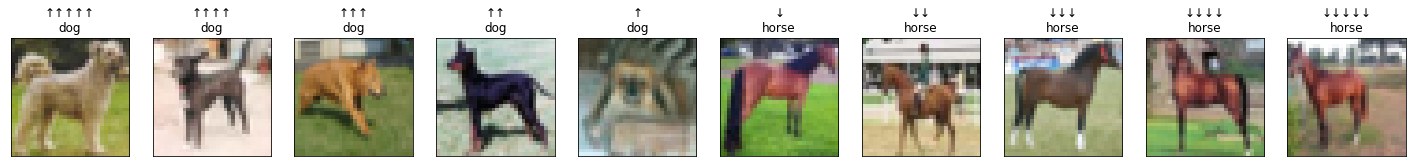

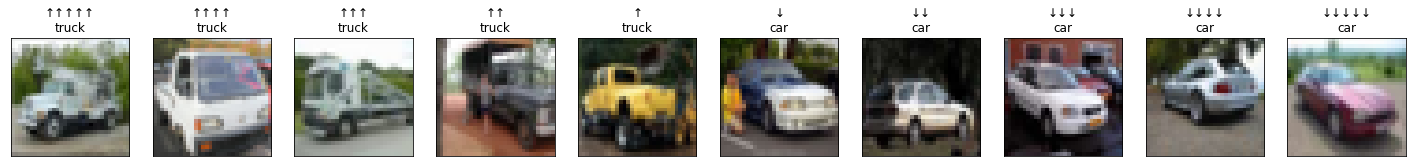

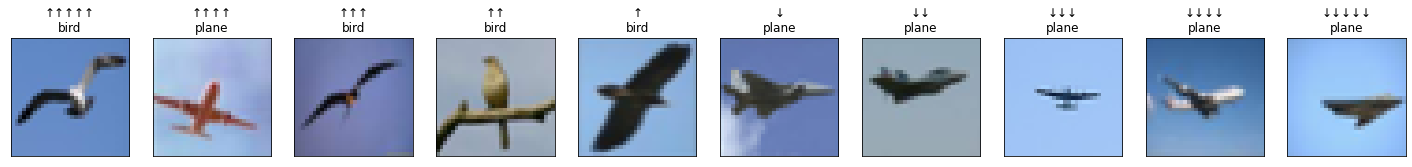

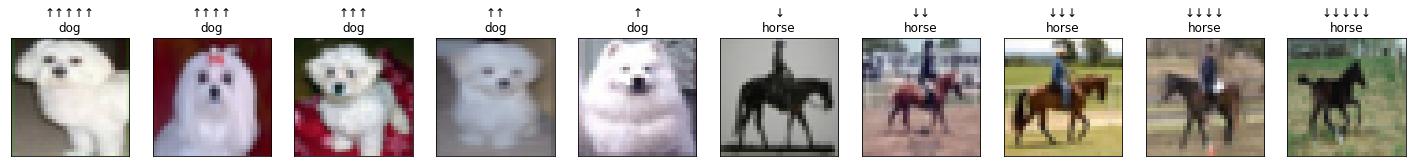

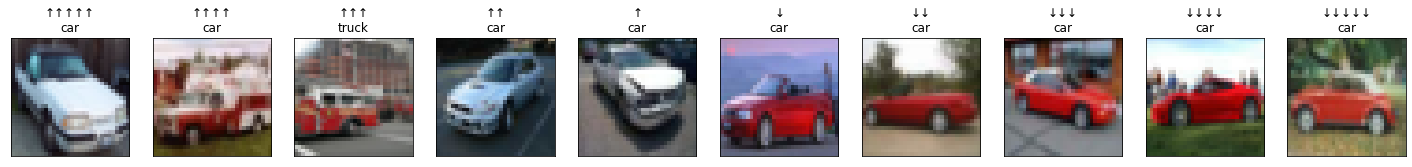

In [66]:
dm_margins.vis_top_PCs()

### Entropy

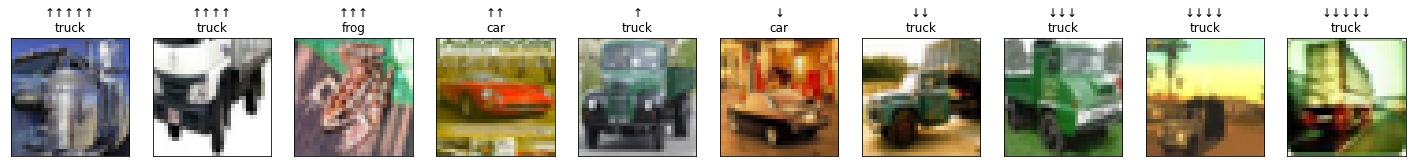

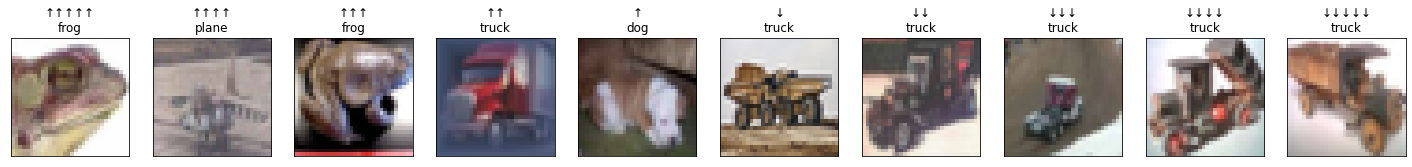

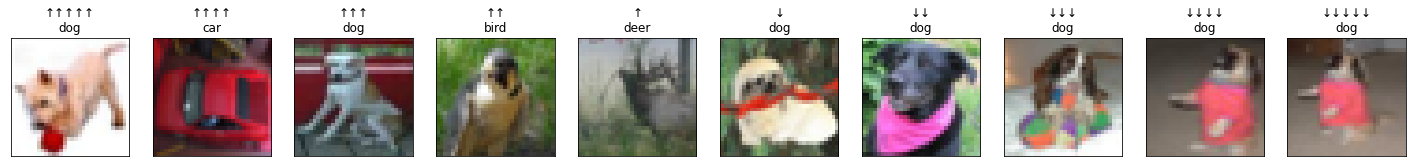

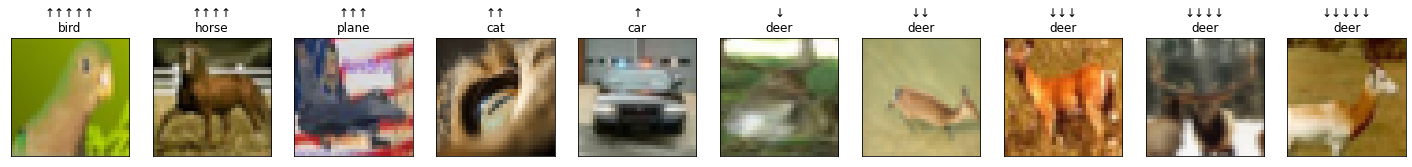

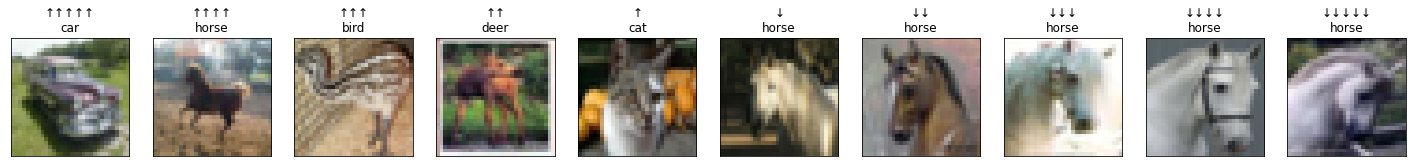

In [67]:
dm_entropy.vis_top_PCs()

## Computing & Evaluating Clusters

In [92]:
pct = 5

### Margins

In [107]:
acc = []
for i in range(10):
    dm_margins.compute_clusters()
    dm_margins.compute_cluster_labels(pct = pct)
    acc.append(dm_margins.cluster_accuracy())
acc = np.array(acc).mean()
print(f"Accuracy: {acc:.2f}%")

Accuracy: 68.47%


In [109]:
acc = []
for i in range(10):
    dm_margins.compute_clusters_split()
    dm_margins.compute_cluster_labels(pct = pct)
    acc.append(dm_margins.cluster_accuracy())
acc = np.array(acc).mean()
print(f"Accuracy: {acc:.2f}%")

Accuracy: 73.24%


### Entropy

In [112]:
acc = []
for i in range(10):
    dm_entropy.compute_clusters()
    dm_entropy.compute_cluster_labels(pct = pct)
    acc.append(dm_entropy.cluster_accuracy())
acc = np.array(acc).mean()
print(f"Accuracy: {acc:.2f}%")

Accuracy: 42.96%


In [113]:
acc = []
for i in range(10):
    dm_entropy.compute_clusters_split()
    dm_entropy.compute_cluster_labels(pct = pct)
    acc.append(dm_entropy.cluster_accuracy())
acc = np.array(acc).mean()
print(f"Accuracy: {acc:.2f}%")

Accuracy: 53.23%
